In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

from skimage.io import imread
import scipy.ndimage
from statsmodels.stats.anova import anova_lm
import scipy.stats as st
from scipy.signal import convolve2d

# Hypothesis Testing Exercise
## Comparing Distributions. Testing statistical hypotheses. p-value. Goodness of fit

### Problem 1. t-test
You're given a dataset which describes the age at death among members of the sovereignty, aristocracy, and gentry. There is an explanation [here](http://www.stat.ufl.edu/~winner/data/agedeath.txt) and the actual data is [here](http://www.stat.ufl.edu/~winner/data/agedeath.dat). Get to know the data; plot histograms and / or boxplots, or other graphs as needed. Note that all ages are only for a certain social class of people and they won't represent the entire population of people.

Do the mean ages differ significantly ($\alpha = 5\%$)? Perform a t-test. Do you need an independent or paired test?

In [3]:
age_data = pd.read_fwf("data/Age Death.dat", header = None)
age_data.drop(2, axis = 1, inplace = True)
age_data.columns = ['category', 'age']
age_data.head()

,category,age
0,aris,21
1,aris,21
2,aris,21
3,aris,21
4,aris,21


In [4]:
age_data['category'].unique()

array(['aris', 'gent', 'sovr'], dtype=object)

In [5]:
age_data['category'].value_counts()

gent    2455
aris    2291
sovr    1440
Name: category, dtype: int64

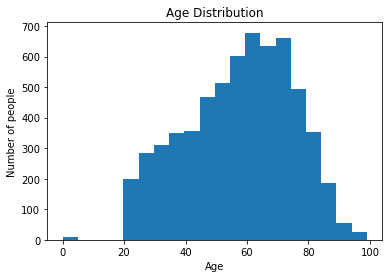

In [6]:
plt.title('Age Distribution')
plt.hist(age_data.age, bins = 20)
plt.xlabel('Age')
plt.ylabel('Number of people')
plt.show()

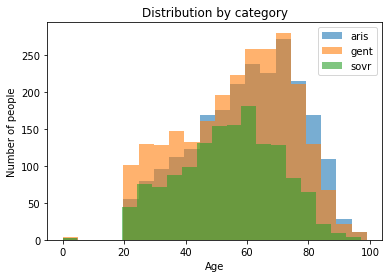

In [7]:
for category, group_data in age_data.groupby('category'):
    plt.hist(group_data['age'], bins = 20, label = category, alpha = 0.6)
plt.title('Distribution by category')
plt.xlabel('Age')
plt.ylabel('Number of people')
plt.legend()
plt.show()

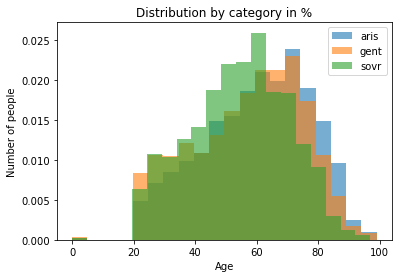

In [8]:
for category, group_data in age_data.groupby('category'):
    plt.hist(group_data['age'], bins = 20, density = True, label = category, alpha = 0.6)
plt.title('Distribution by category in %')
plt.xlabel('Age')
plt.ylabel('Number of people')
plt.legend()
plt.show()

In [9]:
age_data.groupby('category')["age"].mean()

category
aris    60.146224
gent    57.145010
sovr    54.093750
Name: age, dtype: float64

In [10]:
groups = { key: value.tolist() for key, value in age_data.groupby('category').age }
for key in groups.keys():
    print('People count of ' + key + ' type: ' + str(len(groups[key])))
print(st.ttest_ind(groups['aris'], groups['gent']))
print(st.ttest_ind(groups['aris'], groups['sovr']))
print(st.ttest_ind(groups['gent'], groups['sovr']))

People count of aris type: 2291
People count of gent type: 2455
People count of sovr type: 1440
Ttest_indResult(statistic=5.8098209575036135, pvalue=6.662376193720552e-09)
Ttest_indResult(statistic=10.632066783999475, pvalue=4.968340143906721e-26)
Ttest_indResult(statistic=5.2855394856397835, pvalue=1.3221059220353447e-07)


Let's try something else. In the `data/horse_beginners.dat` file, there's data about 8 people. Each person is a beginner in horse riding. They were asked to imagine how long their ride would take (for a fixed track length). After that, the actual times were measured.

Get acquainted with the data and draw some plots if you need (hint: boxplots are useful for comparing distributions). Are the people good at predicting their ride times? That is, are there significant differences between imagined and actual time (5%-level)? Also, is the imagined time **significantly longer** than the real time? Perform a t-test. Don't forget that the subjects are the same.

In [11]:
horse_data = pd.read_fwf('data/horse_beginners.dat')
horse_data.drop('Unnamed: 0', axis = 1, inplace = True)
horse_data.head()

,Subject,Actual,Imaginary
0,S1,69.64,66.58
1,S2,62.26,25.59
2,S3,78.63,24.01
3,S4,76.00,38.35
4,S5,60.10,12.19


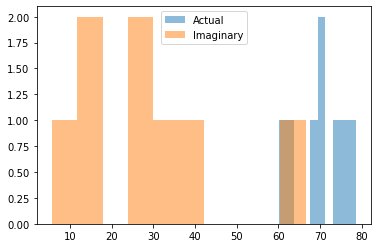

p-value in %: 0.04496024819026769
Actual mean: 69.89874999999999
Imaginary mean: 27.708750000000002
----------------------------------------------------------------------------------------------------
P(Imaginary mean < actual mean): 0.022480124095133846
P(Imaginary mean >= actual mean): 99.97751987590486


In [12]:
plt.hist(horse_data.Actual, alpha = 0.5, label = 'Actual')
plt.hist(horse_data.Imaginary, alpha = 0.5, label = 'Imaginary')
plt.legend()
plt.show()

print('p-value in %: ' + str(st.ttest_rel(horse_data.Actual, horse_data.Imaginary).pvalue * 100))
print('Actual mean: ' + str(horse_data.Actual.mean()))
print('Imaginary mean: ' + str(horse_data.Imaginary.mean()))

print('-' * 100)
# P - Probability
print('P(Imaginary mean < actual mean): ', end = '')

# The null hypothesis is: imaginary mean >= actual mean
# The alternative hypothesis (which we want to prove): imaginary mean < actual mean
# Reject the null hypothesis if the p-value [%] is less than the confidence level (5%)
# p-value [%] for the null hypothesis
print(st.ttest_rel(horse_data.Actual, horse_data.Imaginary).pvalue / 2 * 100)
# p = 0.0225%: probability that we get as extreme or more extreme differences
# assuming that the null hypothesis (H_0) is true
# p < alpha  
# reject H_0

print('P(Imaginary mean >= actual mean): ', end = '')
print(100 - (st.ttest_rel(horse_data.Actual, horse_data.Imaginary).pvalue / 2 * 100))

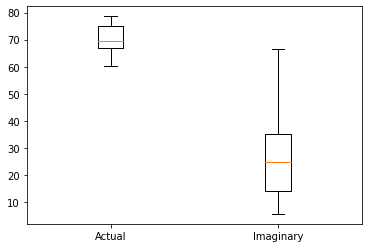

In [13]:
plt.boxplot([horse_data.Actual, horse_data.Imaginary], labels = ['Actual', 'Imaginary'])
plt.show()

### Problem 2. ANOVA
Read [this](http://www.itl.nist.gov/div898/education/anova/newcar.dat) dataset. Get acquainted with it and plot graphics. Note that it's formatted a bit oddly. First, you have to skip some rows; second, the target variable is first (in most datasets, it's the last one). Well, that shouldn't bother you :).

Do the rates differ significantly ($\alpha = 0,05$) between cities? Apply one-way ANOVA to find out.

**Hint:** You have to group all values by city. You can get a dictionary of groups like this:
```python
groups = { k: v.tolist() for k, v in cars.groupby("City").Rate }
```

After that, you can use ```*groups.values()``` to pass all dictionary values as separate arguments to a function.

In [14]:
car_data = pd.read_fwf('data/newcar.dat', header = None, skiprows = 25) 
car_data.columns = ['Rate', 'City']
car_data

,Rate,City
0,13.75,1
1,13.75,1
2,13.50,1
3,13.50,1
4,13.00,1
5,13.00,1
6,13.00,1
7,12.75,1
8,12.50,1
9,14.25,2


F_onewayResult(statistic=4.8293848737024, pvalue=0.001174551414504048)


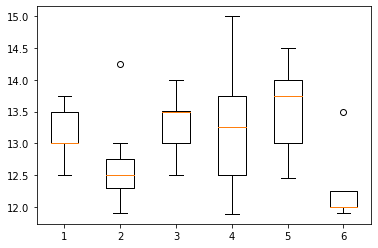

In [15]:
grouped_by_city = { key: value.tolist() for key, value in car_data.groupby('City').Rate }

# The varience of any town compared with the varience of the total dataset
# If the p-value is less than 0.05 here, there is significant difference between one town compared with the other towns
print(st.f_oneway(*grouped_by_city.values()))

plt.boxplot(list(grouped_by_city.values()), labels = range(1, 7))
plt.show()

In [16]:
print(st.f_oneway(grouped_by_city[1], grouped_by_city[6]))
print(st.f_oneway(grouped_by_city[1], grouped_by_city[2]))

F_onewayResult(statistic=19.60293667788314, pvalue=0.00042241578424438383)
F_onewayResult(statistic=4.350828729281767, pvalue=0.05336032220284218)


Well, most analyses aren't so simple. Let's have a look at another dataset. This one is located [here](http://www.itl.nist.gov/div898/education/anova/ratfeed.dat). Get acquainted with it.

This time, we've got two explanatory variables: amount and type of diet.

Perform one-way ANOVA to each variable separately, disregarding the other one. 

To do this, take for example the "Amount" variable. Group all weights by amount, disregarding the diet type. Perform ANOVA on the groups, like you did before. Repeat the same process with "Diet".

Do the groups differ significantly at the 5%-level?

In [17]:
rats_data = pd.read_fwf("https://www.itl.nist.gov/div898/education/anova/ratfeed.dat", skiprows = 25, header = None)
rats_data.columns = ["Weight", "Amount", "Type"]
rats_data

,Weight,Amount,Type
0,118,1,1
1,117,1,1
2,111,1,1
3,107,1,1
4,104,1,1
5,102,1,1
6,100,1,1
7,87,1,1
8,81,1,1
9,73,1,1


In [18]:
rats_data["Amount"].value_counts()

1    30
2    30
Name: Amount, dtype: int64

In [19]:
rats_data["Type"].value_counts()

1    20
2    20
3    20
Name: Type, dtype: int64

In [20]:
rats_data.groupby(["Amount","Type"]).size()

Amount  Type
1       1       10
        2       10
        3       10
2       1       10
        2       10
        3       10
dtype: int64

In [21]:
rats_data.groupby(["Amount","Type"]).Weight.mean()

Amount  Type
1       1       100.0
        2        99.5
        3        85.9
2       1        79.2
        2        78.7
        3        83.9
Name: Weight, dtype: float64

In [22]:
st.f_oneway(rats_data[rats_data["Amount"] == 1]["Weight"], rats_data[rats_data["Amount"] == 2]["Weight"])

F_onewayResult(statistic=14.102077151335312, pvalue=0.00040332283036763615)

In [23]:
st.f_oneway(rats_data[rats_data["Type"] == 1]["Weight"],
            rats_data[rats_data["Type"] == 2]["Weight"],
            rats_data[rats_data["Type"] == 3]["Weight"]
           )

F_onewayResult(statistic=0.47677688232783505, pvalue=0.6232342640383861)

Sometimes we have to take into account multiple values. In this case, we want to ask another question: Is there a significant difference between combinations of diet and amount? These are called **interacting variables**. Unfortunately, there isn't a quick and easy way to perform this test in `scipy.stats`, but `statsmodels` is another library which will come in handy.

We won't go into many details how it works but you basically create a linear model (`ols` stands for "ordinary least squares") and you provide a formula. The formula we want to use looks like this:
```python
formula = "Weight ~ C(Amount) + C(Diet) + C(Amount):C(Diet)"
```

`Weight`, `Amount` and `Diet` are the **column names** (i.e. variable names) in the dataset. `C(Amount)` tells the library to treat the variable as *categorical*, not numerical (e.g. diet 1 + diet 3 makes absolutely no sense). Finally `C(Amount):C(Diet)` means that we take the interaction between these categories (Cartesian product - every amount with every diet).

How do we read this formula? "The Weight column is proportional to the categories Amount, Diet and their interaction" (i.e. Weight is a linear combination of the three other variables).

We are now ready. Well, we could have done all this by hand as well, but why bother :)? Just create the linear model:
```python
model = ols(formula, rats).fit()
```

and the ANOVA table:
```python
table = statsmodels.stats.anova.anova_lm(model, typ = 2)
```

You can see there's "type 2" ANOVA chosen. If you're interested, you can read more about the three types of ANOVA [here](https://mcfromnz.wordpress.com/2011/03/02/anova-type-iiiiii-ss-explained/)

P. S.: The type of formulas we described above are typical for another popular language for statistics and data analysis, called **R**. They're also why many people hate R. They're good but need a bit of understanding and getting accustomed to. Case closed :D.

In [24]:
formula = "Weight ~ C(Amount) + C(Type) + C(Amount):C(Type)"
model = ols(formula, rats_data).fit()

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     4.300
Date:                Sun, 12 Jun 2022   Prob (F-statistic):            0.00230
Time:                        17:23:16   Log-Likelihood:                -243.03
No. Observations:                  60   AIC:                             498.1
Df Residuals:                      54   BIC:                             510.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     100.0000      4.632     21.589      0.000      90.713     109.287
C(Amount)[T.2]                -20.8000      6.551     -3.175      0.002     -33.933      -7.667
C(Type)[T.2]                   -0.5000      6.551     -0.076      0.939     -13.633      12.633
C(Type)[T.3]                  -14.1000      6.551     -2.152      0.036     -27.233      -0.967
C(Amount)[T.2]:C(Type)[T.2]  1.228e-13      9.264   1.33e-14      1.000     -18.573      18.573
C(Amount)[T.2]:C(Type)[T.3]    18.8000      9.264      2.029      0.047       0.227      37.373
==============================================================================
Omnibus:                        1.646   Durbin-Watson:                   1.277
Prob(Omnibus):                  0.439   Jarque-Bera (JB):                1.647
Skew:                          -0.349   Prob(JB):                        0.439
Kurtosis:                       2.585   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
anova_lm(model, typ = 2)

,sum_sq,df,F,PR(>F)
C(Amount),3168.266667,1.0,14.766649,0.000322
C(Type),266.533333,2.0,0.621129,0.541132
C(Amount):C(Type),1178.133333,2.0,2.745520,0.073188
Residual,11586.000000,54.0,NaN,NaN


### Problem 3. Contingency Tables. $\chi^2$-test
Have a look at the dataset `data/Popular Kids.tsv` and its description `data/Popular Kids Description.txt`.

When we want to compare data across many categories, a useful way we can visualize it, is using **contingency tables** (or two-way tables). One variable goes to the rows, another one - to the columns of the table. The intersection cell represents the number of observations having this combination of values.

Try it now:
```python
pd.crosstab(kids.Grade, kids.Goals)
```

You can also specify multiple columns - this will create higher-dimensional tables. Keep in mind, however, that these are difficult to look at and understand. We're usually fine with two variables, three in some rare cases.

In [27]:
kids_data = pd.read_table('data/Popular Kids.tsv')
kids_data

,Gender,Grade,Age,Race,Urban/Rural,School,Goals,Grades,Sports,Looks,Money
0,boy,5,11,White,Rural,Elm,Sports,1,2,4,3
1,boy,5,10,White,Rural,Elm,Popular,2,1,4,3
2,girl,5,11,White,Rural,Elm,Popular,4,3,1,2
3,girl,5,11,White,Rural,Elm,Popular,2,3,4,1
4,girl,5,10,White,Rural,Elm,Popular,4,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...
473,boy,6,11,White,Urban,Westdale Middle,Grades,4,1,2,3
474,boy,6,11,White,Urban,Westdale Middle,Sports,4,1,2,3
475,boy,6,11,White,Urban,Westdale Middle,Grades,4,2,1,3
476,boy,6,11,White,Urban,Westdale Middle,Popular,4,1,3,2


In [28]:
grade_goals_crosstab = pd.crosstab(kids_data.Grade, kids_data.Goals)
grade_goals_crosstab

Goals,Grades,Popular,Sports
Grade,,,
4,63,31,25
5,88,55,33
6,96,55,32


The **$\chi^2$**-test provides a way to test for association between two (or more) categorical variables. In this case, **Grade** and **Goals** seem to be good candidates. This is most easily done using the contingency table. Fortunately, `scipy.stats` has one such method (read the docs [here](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.chi2_contingency.html)).

Note that this test doesn't specify what the relationship is. It just tells us that there might be a significant relationship.

Are goals related to grade? To what extent? Are these significant?
* $H_0$: No relation between Grade and Goals
* $H_1$: Some relation exists between Grade and Goals
* $\alpha = 0,05$

In [29]:
chi2, pvalue, dof, expected = st.chi2_contingency(grade_goals_crosstab)
pvalue
# p-value is greater than 0.05 
# reject the null hypothesis (H_0)

0.8593185000807877

The school areas are also divided into "Urban", "Suburban" and "Rural". Are the school areas related to goals? Perform the same type of test. Is the difference significant now?

In [30]:
goals_areas_crosstab = pd.crosstab(kids_data.Goals, kids_data['Urban/Rural'])
goals_areas_crosstab

Urban/Rural,Rural,Suburban,Urban
Goals,,,
Grades,57,87,103
Popular,50,42,49
Sports,42,22,26


In [31]:
chi2, pvalue, dof, expected = st.chi2_contingency(goals_areas_crosstab)
pvalue
# p-value is less than 0.05
# reject the null hypothesis (H_0)

0.0008496551610398188

Feel free to continue exploring the dataset as you wish. You can find interesting data and relationships. 

**Note:** You'll see the catch of categorical variables - these are very difficult to visualize properly. Most plots just appear as symmetrical patterns of dots. You can rely on contingency tables and correlations to properly describe and explore these variables.

In [32]:
grade_areas_crosstab = pd.crosstab(kids_data.Grade, kids_data['Urban/Rural'])
grade_areas_crosstab

Urban/Rural,Rural,Suburban,Urban
Grade,,,
4,44,22,53
5,53,46,77
6,52,83,48


In [33]:
chi2, pvalue, dof, expected = st.chi2_contingency(grade_areas_crosstab)
pvalue
# p-values is less than 0.05, there is significant difference between grade and areas

3.7670937698959237e-06

### * Problem 4. Image Convolution
"Convolution" refers to a process similar to "mixing" two functions. It can be performed in one dimension (e.g. on audio data), or many dimensions. In this problem, we'll look at 2D convolution of images and what we can do with it.

Let's first read an image. Once again, to make things easier, we'll separate the channels. We can work on all three channels separately or at once but it's easier to work with one channel only.

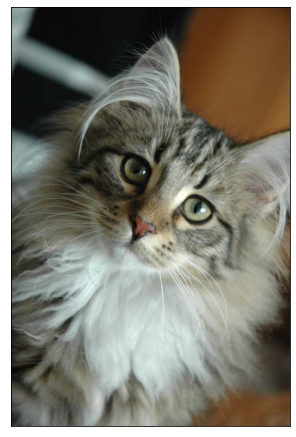

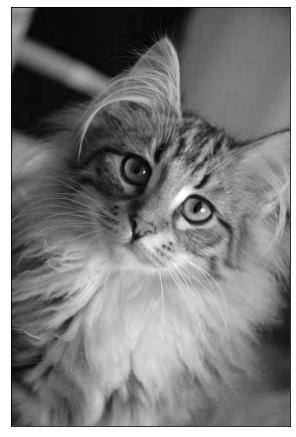

In [34]:
original_image = imread("https://upload.wikimedia.org/wikipedia/commons/d/d9/Norwegian_Forest_Cat_Portrait.JPG")

def display(image):
    # If there is only one channel to show, display it as grayscale
    cm = None
    if(len(image.shape)) == 2:
        cm = "gray"
    plt.figure(figsize = (5, 10))
    plt.imshow(image, cmap = cm)
    plt.xticks([])
    plt.yticks([])
    plt.show()

display(original_image)
r = original_image[:, :, 0]
display(r)

**Convolution** means taking a special square matrix (usually 3x3 or 5x5), called a **convolution kernel** and applying it to the image like this: the central pixel of the resulting image is the sum of element-wise products between the image and the kernel:
![Convolution example](convolution.png)

After that, the kernel moves 1px to the right and contiinues. It "slides" across the entire image. The edge pixels are a bit problematic but there are several ways to deal with that. The most common way is to copy whatever pixel value happened to be at the border.

![Border handling](border.png)

The algorithm is always the same. The output depends on the **kernel**. Different kernels produce different results: some detect edges (lines), others detect corners; some apply blurring and sharpening; some remove noise, etc.

The results can be useful for analyzing what's on the image, or just for artistic purposes.

Let's examine this filter, for example:

$$ F = \begin{bmatrix}
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9
\end{bmatrix}
$$

This calculates the average of all surrounding pixels and basically smooths the image.

Note that in order to preserve brightness, the sum of all elements in $F$ must be equal to 1. If it's not, the image will be darker or brighter (which may or may not be a desired effect).

`scipy.ndimage` has a method for performing 1D and multi-dimensional convolution. Read the docs [here](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.filters.convolve.html#scipy.ndimage.filters.convolve).

Apply the convolution. To see better how it performs, you can plot only a part of the image - this will zoom the entire thing. Compare the "before" and "after" images.

In [35]:
size = 5
kernel = np.ones(shape = (size,size)) / size**2
result = scipy.ndimage.convolve(r, kernel)

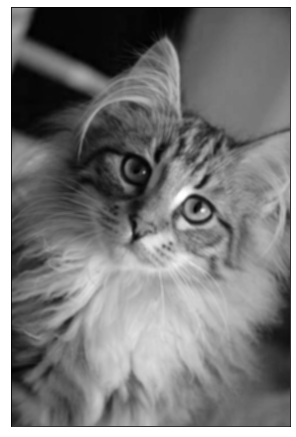

In [36]:
display(result)

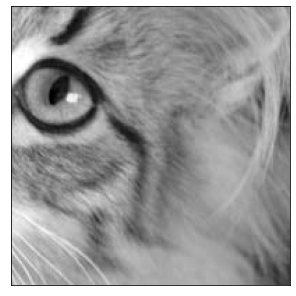

In [37]:
display(r[300:500 , 300:500])

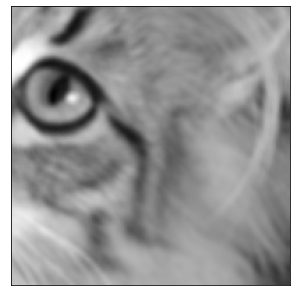

In [38]:
display(result[300:500 , 300:500])

In [39]:
kernel = [
    [0, 1, 0],
    [0, 0, 0],
    [0, 0, 0]
    
]

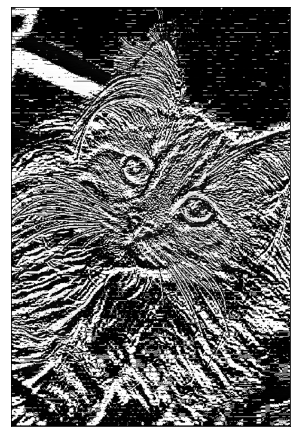

In [40]:
result = scipy.ndimage.convolve(r, kernel)
display(result - r)

Play around with more kernels (they're also called **filters**). You can find examples on the Internet, or you can create your own. Have fun :).

Try these filters:
* Gaussian blur
* Sobel edge detector - vertical, horizontal
* Corner detector
* Gradient detector
* Sharpening
* Unsharp mask

For each filter, show the result before and after its application.

Sources: <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing)">Wikipedia</a>, [online playground](http://matlabtricks.com/post-5/3x3-convolution-kernels-with-online-demo), [Image Kernels explained visually](http://setosa.io/ev/image-kernels/).

**Optional:** Think about you might use edge, corner and gradient detectors in image processing.

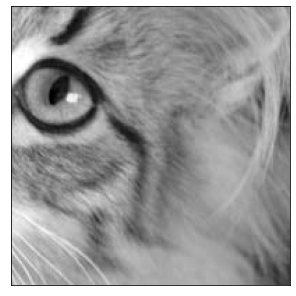

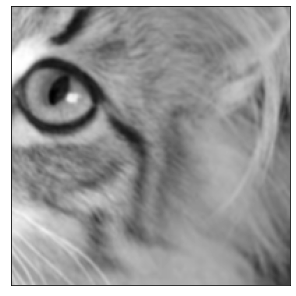

In [41]:
gaussian_blur_filter = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16

filtered_image = scipy.ndimage.filters.convolve(r, gaussian_blur_filter)
display(r[300:500, 300:500])
display(filtered_image[300:500, 300:500])
